In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style("ticks",{'axes.grid' : True})

In [2]:
dados = pd.read_csv('linha150.csv',
                    converters={
                        'linha': str,
                        'trajeto': str,
                        'ponto_inicial': str,
                        'ponto_final': str,
                        'servico': str
                    },
                    parse_dates=['data', 'inicior', 'terminor'])


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68834 entries, 0 to 68833
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   linha          68834 non-null  object        
 1   data           68834 non-null  datetime64[ns]
 2   trajeto        68834 non-null  object        
 3   ponto_inicial  68834 non-null  object        
 4   ponto_final    68834 non-null  object        
 5   servico        68834 non-null  object        
 6   inicior        68834 non-null  datetime64[ns]
 7   terminor       68834 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(5)
memory usage: 4.2+ MB


In [4]:
dados['mintrajeto'] = ((dados['terminor'] - dados['inicior']).dt.total_seconds()/ 60.0).astype('int')
dados['diasemana'] = dados['data'].dt.dayofweek

dias = {0: 'Segunda', 1: 'Terça', 2: 'Quarta',
        3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}

dados['nomediasemana'] = dados['diasemana'].apply(lambda x: dias[x])


In [5]:
dados.head()

,linha,data,trajeto,ponto_inicial,ponto_final,servico,inicior,terminor,mintrajeto,diasemana,nomediasemana
0,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 05:25:00,2018-01-10 05:39:00,14,2,Quarta
1,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 05:58:00,2018-01-10 06:12:00,14,2,Quarta
2,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 06:37:00,2018-01-10 06:54:00,17,2,Quarta
3,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:09:00,2018-01-10 07:36:00,27,2,Quarta
4,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:56:00,2018-01-10 08:25:00,29,2,Quarta


In [6]:
dados['trajeto'].unique()

array(['150_A - Terminal Cordeiros > Terminal Fazenda',
       '150_B - Univali / T. Fazenda / T. Cordeiros'], dtype=object)

In [7]:
dados = dados.loc[dados['trajeto'] != '150_B - Univali / T. Fazenda / T. Cordeiros']

# Média mensal (seg./sexta)

In [8]:
dados['ano'] = dados['data'].dt.year
dados['mes'] = dados['data'].dt.month
dados['dia'] = dados['data'].dt.day
dados['hora'] = dados['inicior'].dt.hour
dados['diadoano'] = dados['data'].dt.dayofyear
dados['intervalohora'] = pd.cut(dados['hora'],
                                [0, 6, 9, 12, 15, 18, 21, 24],
                                labels=['0-5', '6-8', '9-11', '12-14',
                                        '15-17', '18-20', '21-24'],
                                right=False)

dados_dias_semana = dados[dados['diasemana'].isin([0,1,2,3,4])]

# Desenvolvimento durante o ano

In [9]:
dados_ano = dados_dias_semana.groupby(['ano', 'diadoano'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_ano.head()

,index,ano,diadoano,mintrajeto
0,0,2018,1,39.105263
1,1,2018,2,37.698113
2,2,2018,3,26.616667
3,3,2018,4,27.446154
4,4,2018,5,25.424658


In [10]:
# Desenvolvimento durante o ano, terminal Cordeiros -> terminal Fazenda

In [11]:
dados_ano_cordeiros_fazenda = dados_dias_semana.loc[(dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'diadoano'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_ano_cordeiros_fazenda.head()


,index,ano,diadoano,mintrajeto
0,0,2018,1,17.000000
1,1,2018,2,20.600000
2,2,2018,3,19.583333
3,3,2018,4,19.800000
4,4,2018,5,20.903226


Text(0, 0.5, 'Tempo (minutos)')

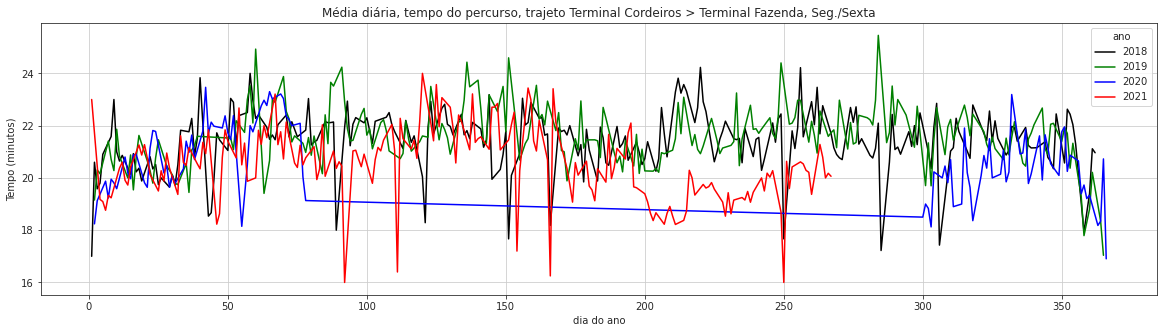

In [12]:
fig, ax = pyplot.subplots(figsize=(20, 5))
diaria_anual_cordeiros_fazenda = sns.lineplot(data=dados_ano_cordeiros_fazenda, x='diadoano', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
diaria_anual_cordeiros_fazenda.set_title(
    "Média diária, tempo do percurso, trajeto Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
diaria_anual_cordeiros_fazenda.set_xlabel("dia do ano", fontsize=10)
diaria_anual_cordeiros_fazenda.set_ylabel("Tempo (minutos)", fontsize=10)

# Desenvolvimento durante o ano, terminal Fazenda -> terminal Cordeiros

In [13]:
dados_ano_fazenda_cordeiros = dados_dias_semana.loc[(dados['ponto_inicial'] == 'Terminal Fazenda')& (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'diadoano'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_ano_cordeiros_fazenda.head()

,index,ano,diadoano,mintrajeto
0,0,2018,1,17.000000
1,1,2018,2,20.600000
2,2,2018,3,19.583333
3,3,2018,4,19.800000
4,4,2018,5,20.903226


Text(0, 0.5, 'Tempo (minutos)')

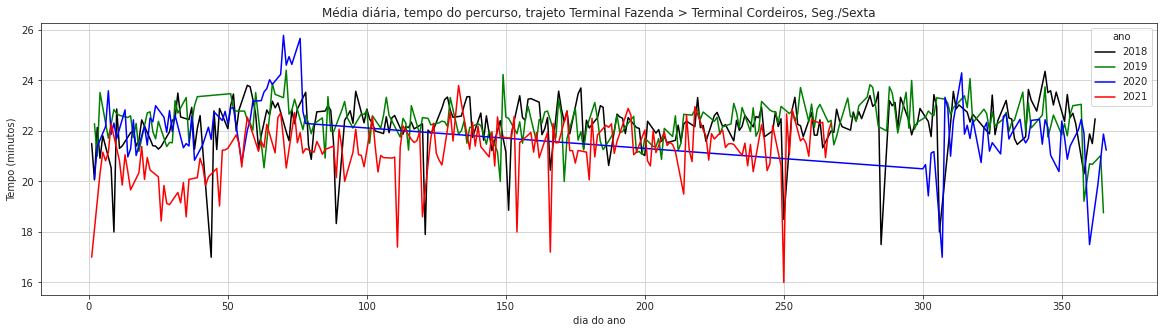

In [14]:
fig, ax = pyplot.subplots(figsize=(20, 5))
diaria_anual_fazenda_cordeiros = sns.lineplot(data=dados_ano_fazenda_cordeiros, x='diadoano', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
diaria_anual_fazenda_cordeiros.set_title(
    "Média diária, tempo do percurso, trajeto Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
diaria_anual_fazenda_cordeiros.set_xlabel("dia do ano", fontsize=10)
diaria_anual_fazenda_cordeiros.set_ylabel("Tempo (minutos)", fontsize=10)

# Média mensal

In [15]:
dados_mes = dados_dias_semana.loc[(dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_mes.head()

,index,ano,mes,mintrajeto
0,0,2018,1,20.964898
1,1,2018,2,22.214286
2,2,2018,3,22.166794
3,3,2018,4,22.108904
4,4,2018,5,21.989179


Text(0, 0.5, 'Tempo (minutos)')

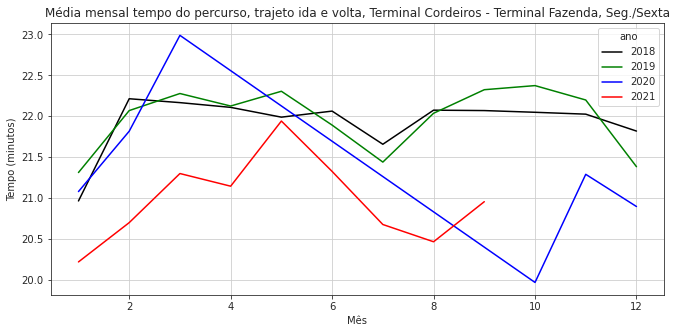

In [16]:
fig, ax = pyplot.subplots(figsize=(11, 5))
mensal = sns.lineplot(data=dados_mes, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal.set_title(
    "Média mensal tempo do percurso, trajeto ida e volta, Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
mensal.set_xlabel("Mês", fontsize=10)
mensal.set_ylabel("Tempo (minutos)", fontsize=10)


Text(0, 0.5, 'Tempo (minutos)')

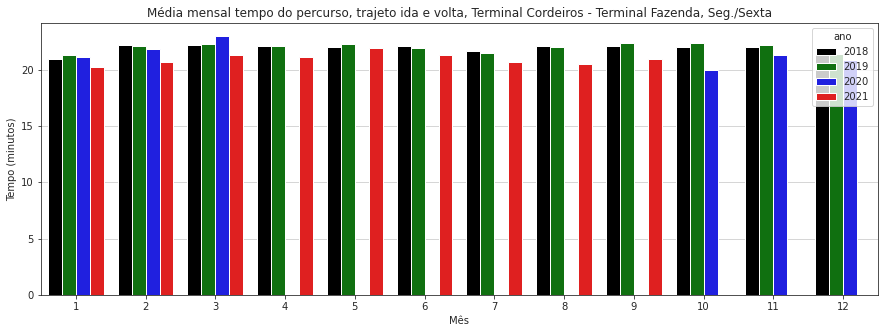

In [17]:
fig, ax = pyplot.subplots(figsize=(15, 5))
mensal = sns.barplot(data=dados_mes, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal.set_title(
    "Média mensal tempo do percurso, trajeto ida e volta, Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
mensal.set_xlabel("Mês", fontsize=10)
mensal.set_ylabel("Tempo (minutos)", fontsize=10)


# Média mensal, terminal Fazenda -> terminal Cordeiros

In [18]:
dados_mes_fazenda_cordeiros = dados_dias_semana.loc[(dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_mes_fazenda_cordeiros.head()

,index,ano,mes,mintrajeto
0,0,2018,1,21.677083
1,1,2018,2,22.631236
2,2,2018,3,22.453834
3,3,2018,4,22.388430
4,4,2018,5,22.289509


Text(0, 0.5, 'Tempo (minutos)')

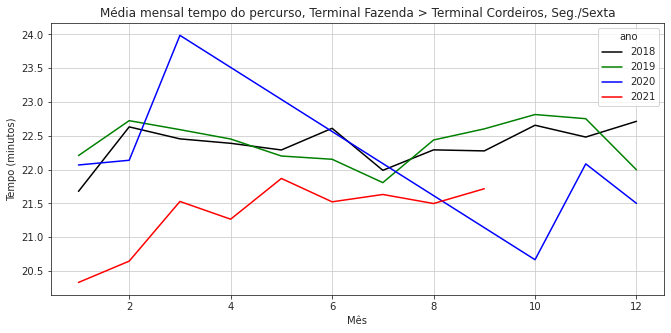

In [19]:
fig, ax = pyplot.subplots(figsize=(11, 5))
mensal_fazenda_cordeiros = sns.lineplot(data=dados_mes_fazenda_cordeiros, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal_fazenda_cordeiros.set_title(
    "Média mensal tempo do percurso, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
mensal_fazenda_cordeiros.set_xlabel("Mês", fontsize=10)
mensal_fazenda_cordeiros.set_ylabel("Tempo (minutos)", fontsize=10)


Text(0, 0.5, 'Tempo (minutos)')

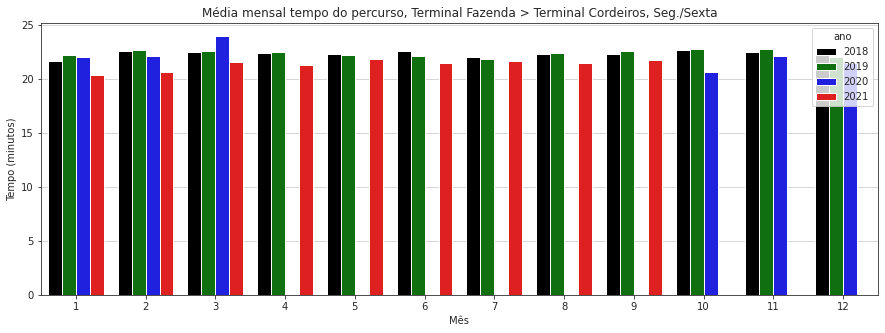

In [20]:
fig, ax = pyplot.subplots(figsize=(15, 5))
mensal_fazenda_cordeiros = sns.barplot(data=dados_mes_fazenda_cordeiros, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal_fazenda_cordeiros.set_title(
    "Média mensal tempo do percurso, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
mensal_fazenda_cordeiros.set_xlabel("Mês", fontsize=10)
mensal_fazenda_cordeiros.set_ylabel("Tempo (minutos)", fontsize=10)


# Média mensal, terminal Cordeiros -> terminal Fazenda

In [21]:
dados_mes_cordeiros_fazenda = dados_dias_semana.loc[(dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_mes_cordeiros_fazenda.head()

,index,ano,mes,mintrajeto
0,0,2018,1,20.332820
1,1,2018,2,21.799136
2,2,2018,3,21.892216
3,3,2018,4,21.832425
4,4,2018,5,21.712714


Text(0, 0.5, 'Tempo (minutos)')

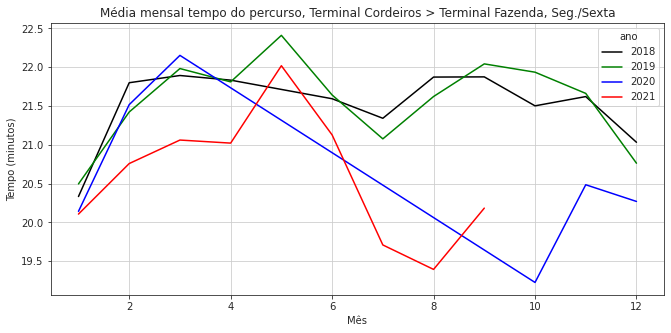

In [22]:
fig, ax = pyplot.subplots(figsize=(11, 5))
mensal_cordeiros_fazenda = sns.lineplot(data=dados_mes_cordeiros_fazenda, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal_cordeiros_fazenda.set_title(
    "Média mensal tempo do percurso, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
mensal_cordeiros_fazenda.set_xlabel("Mês", fontsize=10)
mensal_cordeiros_fazenda.set_ylabel("Tempo (minutos)", fontsize=10)


Text(0, 0.5, 'Tempo (minutos)')

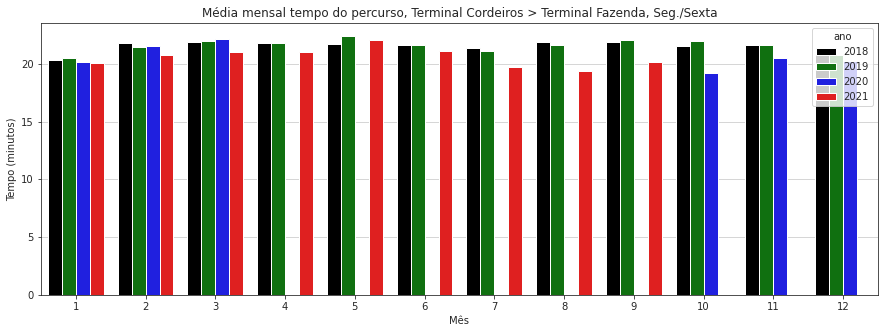

In [23]:
fig, ax = pyplot.subplots(figsize=(15, 5))
mensal_cordeiros_fazenda = sns.barplot(data=dados_mes_cordeiros_fazenda, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal_cordeiros_fazenda.set_title(
    "Média mensal tempo do percurso, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
mensal_cordeiros_fazenda.set_xlabel("Mês", fontsize=10)
mensal_cordeiros_fazenda.set_ylabel("Tempo (minutos)", fontsize=10)


# Média diária

In [24]:
dados_dias = dados_dias_semana.groupby(['ano', 'dia'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_dias.head()

,index,ano,dia,mintrajeto
0,0,2018,1,23.984906
1,1,2018,2,24.372263
2,2,2018,3,24.937984
3,3,2018,4,23.695324
4,4,2018,5,24.234899


Text(0, 0.5, 'Tempo (minutos)')

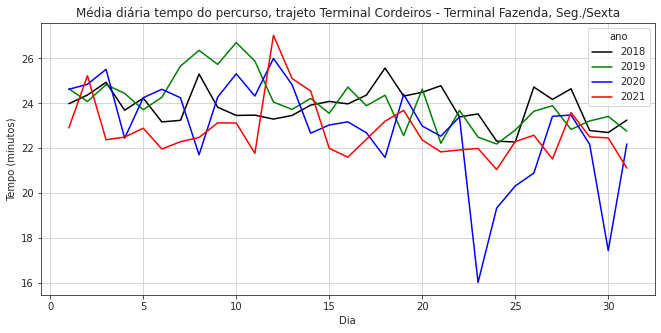

In [25]:
fig, ax = pyplot.subplots(figsize=(11, 5))
diario = sns.lineplot(data=dados_dias, x='dia', y='mintrajeto',
                      hue='ano', palette=['black', 'green', 'blue', 'red'])
diario.set_title(
    "Média diária tempo do percurso, trajeto Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
diario.set_xlabel("Dia", fontsize=10)
diario.set_ylabel("Tempo (minutos)", fontsize=10)


# Comparação dias da semana

In [26]:
dados_comp_dias_semana = dados_dias_semana.groupby(['ano', 'mes', 'nomediasemana','diasemana'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_comp_dias_semana.sort_values(by=['diasemana'], inplace=True)

dados_comp_dias_semana.head()

,index,ano,mes,nomediasemana,diasemana,mintrajeto
97,97,2019,8,Segunda,0,22.122762
27,27,2018,6,Segunda,0,22.656757
137,137,2020,10,Segunda,0,14.888889
62,62,2019,1,Segunda,0,29.174905
32,32,2018,7,Segunda,0,22.843400


Text(0, 0.5, 'Tempo (minutos)')

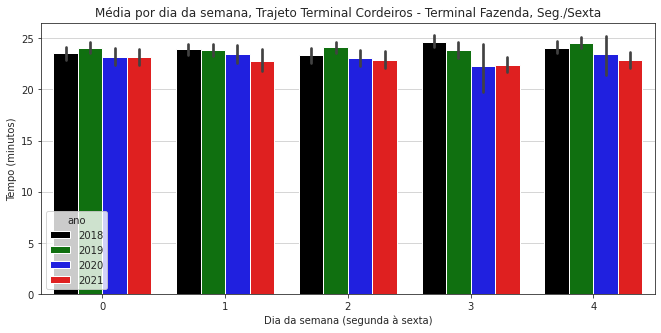

In [27]:
fig, ax = pyplot.subplots(figsize=(11, 5))
dia_semana = sns.barplot(data=dados_dias_semana, x='diasemana', y='mintrajeto',
                         hue='ano', palette=['black', 'green', 'blue', 'red'])
dia_semana.set_title(
    "Média por dia da semana, Trajeto Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
dia_semana.set_xlabel("Dia da semana (segunda à sexta)", fontsize=10)
dia_semana.set_ylabel("Tempo (minutos)", fontsize=10)


# Média mensal, por faixa de horário

intervalos:

0-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-24'

In [28]:
dados.head()

,linha,data,trajeto,ponto_inicial,ponto_final,servico,inicior,terminor,mintrajeto,diasemana,nomediasemana,ano,mes,dia,hora,diadoano,intervalohora
0,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 05:25:00,2018-01-10 05:39:00,14,2,Quarta,2018,1,10,5,10,0-5
1,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 05:58:00,2018-01-10 06:12:00,14,2,Quarta,2018,1,10,5,10,0-5
2,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 06:37:00,2018-01-10 06:54:00,17,2,Quarta,2018,1,10,6,10,6-8
3,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:09:00,2018-01-10 07:36:00,27,2,Quarta,2018,1,10,7,10,6-8
4,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:56:00,2018-01-10 08:25:00,29,2,Quarta,2018,1,10,7,10,6-8


In [29]:
cf_dados_6_8 = dados_dias_semana.loc[(dados['intervalohora'] == '6-8') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

cf_dados_9_11 = dados_dias_semana.loc[(dados['intervalohora'] == '9-11') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

cf_dados_12_14 = dados_dias_semana.loc[(dados['intervalohora'] == '12-14') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

cf_dados_15_17 = dados_dias_semana.loc[(dados['intervalohora'] == '15-17') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

cf_dados_18_20 = dados_dias_semana.loc[(dados['intervalohora'] == '18-20') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

cf_dados_21_24 = dados_dias_semana.loc[(dados['intervalohora'] == '21-24') & (dados['ponto_inicial'] == 'Terminal Cordeiros') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_6_8 = dados_dias_semana.loc[(dados['intervalohora'] == '6-8') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_9_11 = dados_dias_semana.loc[(dados['intervalohora'] == '9-11') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_12_14 = dados_dias_semana.loc[(dados['intervalohora'] == '12-14') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_15_17 = dados_dias_semana.loc[(dados['intervalohora'] == '15-17') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_18_20 = dados_dias_semana.loc[(dados['intervalohora'] == '18-20') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

fc_dados_21_24 = dados_dias_semana.loc[(dados['intervalohora'] == '21-24') & (dados['ponto_inicial'] == 'Terminal Fazenda') & (dados['mintrajeto'] > 15) & (dados['mintrajeto'] < 32)].groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()


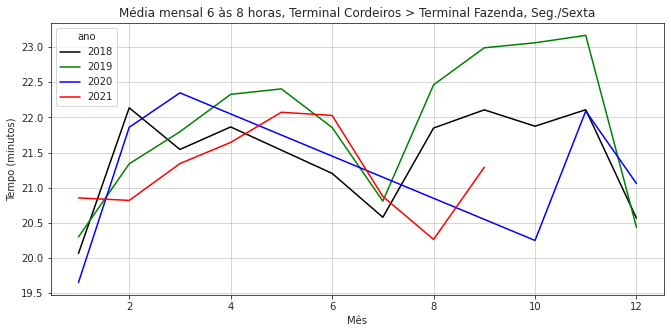

In [30]:
# Terminal Cordeiros > Terminal Fazenda, 6-8
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_6_8 = sns.lineplot(data=cf_dados_6_8, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_6_8.set_title(
    "Média mensal 6 às 8 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_6_8.set_xlabel("Mês", fontsize=10)
plot_cf_dados_6_8.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_6_8.png')


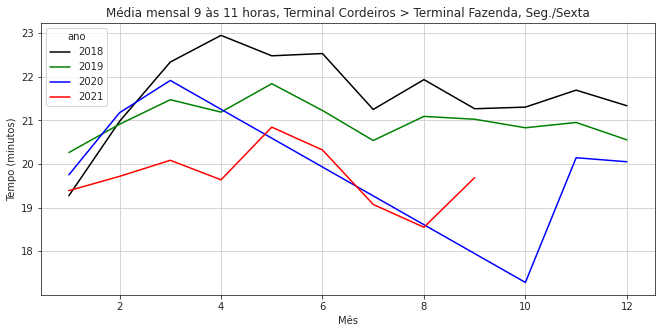

In [31]:
# Terminal Cordeiros > Terminal Fazenda, 9-11
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_9_11 = sns.lineplot(data=cf_dados_9_11, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_9_11.set_title(
    "Média mensal 9 às 11 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_9_11.set_xlabel("Mês", fontsize=10)
plot_cf_dados_9_11.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_9_11.png')


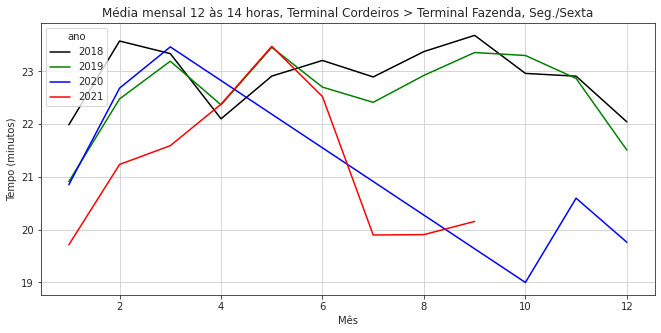

In [32]:
# Terminal Cordeiros > Terminal Fazenda, 12-14
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_12_14 = sns.lineplot(data=cf_dados_12_14, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_12_14.set_title(
    "Média mensal 12 às 14 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_12_14.set_xlabel("Mês", fontsize=10)
plot_cf_dados_12_14.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_12_14.png')


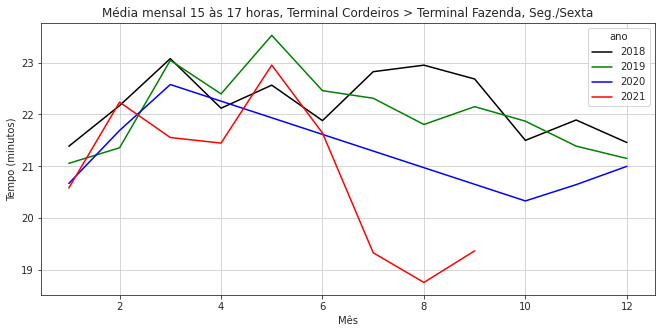

In [33]:
# Terminal Cordeiros > Terminal Fazenda, 15-17
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_15_17 = sns.lineplot(data=cf_dados_15_17, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_15_17.set_title(
    "Média mensal 15 às 17 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_15_17.set_xlabel("Mês", fontsize=10)
plot_cf_dados_15_17.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_15_17.png')


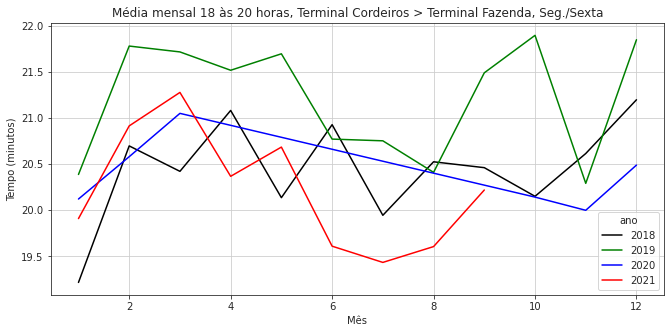

In [34]:
# Terminal Cordeiros > Terminal Fazenda, 18-20
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_18_20 = sns.lineplot(data=cf_dados_18_20, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_18_20.set_title(
    "Média mensal 18 às 20 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_18_20.set_xlabel("Mês", fontsize=10)
plot_cf_dados_18_20.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_18_20.png')


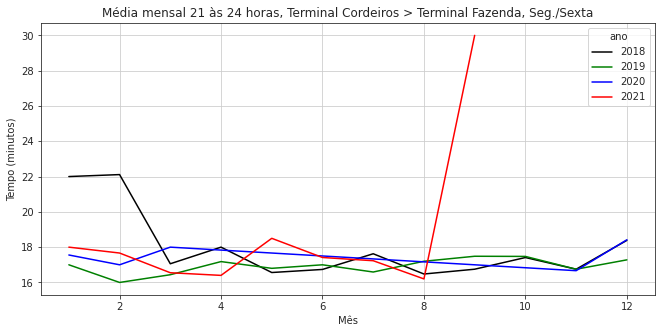

In [35]:
# Terminal Cordeiros > Terminal Fazenda, 21-24
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_cf_dados_21_24 = sns.lineplot(data=cf_dados_21_24, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_cf_dados_21_24.set_title(
    "Média mensal 21 às 24 horas, Terminal Cordeiros > Terminal Fazenda, Seg./Sexta")
plot_cf_dados_21_24.set_xlabel("Mês", fontsize=10)
plot_cf_dados_21_24.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Cordeiros_Fazenda_21_24.png')


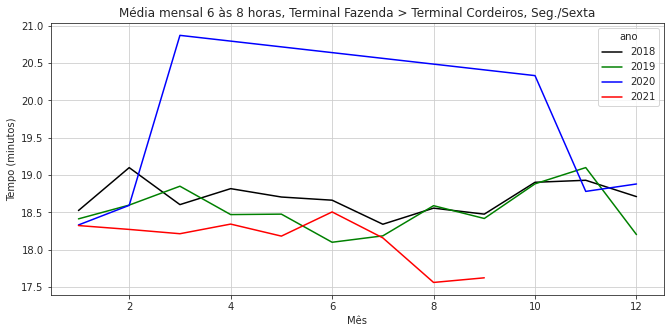

In [36]:
# Terminal Fazenda > Terminal Cordeiros, 6-8
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_6_8 = sns.lineplot(data=fc_dados_6_8, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_6_8.set_title(
    "Média mensal 6 às 8 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_6_8.set_xlabel("Mês", fontsize=10)
plot_fc_dados_6_8.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_6_8.png')


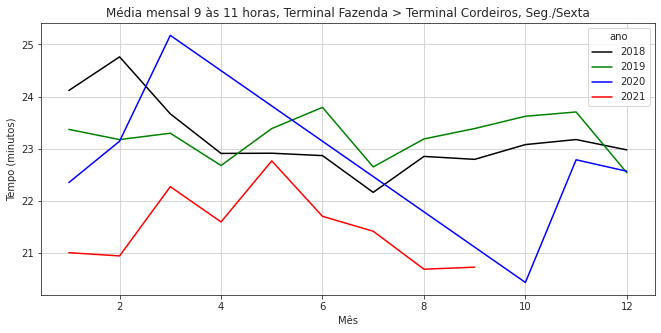

In [37]:
# Terminal Fazenda > Terminal Cordeiros, 9-11
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_9_11 = sns.lineplot(data=fc_dados_9_11, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_9_11.set_title(
    "Média mensal 9 às 11 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_9_11.set_xlabel("Mês", fontsize=10)
plot_fc_dados_9_11.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_9_11.png')


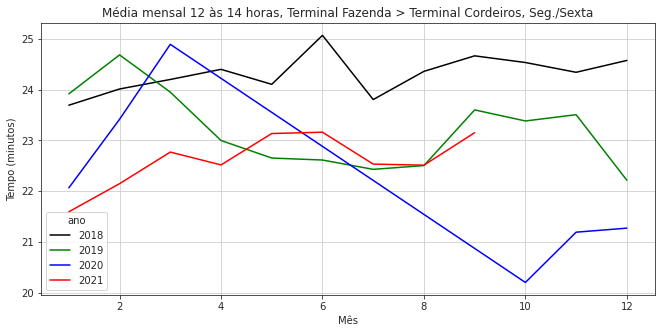

In [38]:
# Terminal Fazenda > Terminal Cordeiros, 12-14
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_12_14 = sns.lineplot(data=fc_dados_12_14, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_12_14.set_title(
    "Média mensal 12 às 14 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_12_14.set_xlabel("Mês", fontsize=10)
plot_fc_dados_12_14.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_12_14.png')


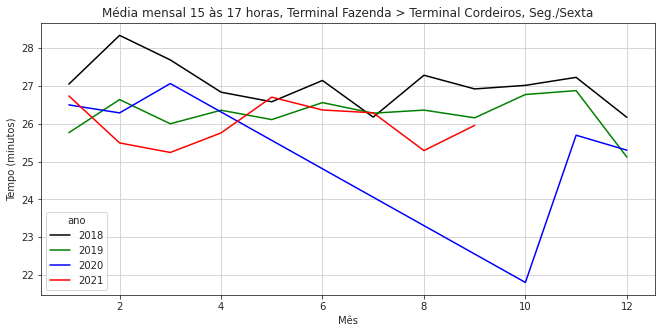

In [39]:
# Terminal Fazenda > Terminal Cordeiros, 15-17
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_15_17 = sns.lineplot(data=fc_dados_15_17, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_15_17.set_title(
    "Média mensal 15 às 17 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_15_17.set_xlabel("Mês", fontsize=10)
plot_fc_dados_15_17.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_15_17.png')


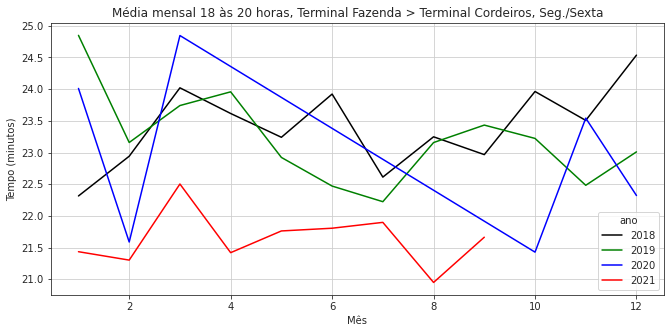

In [40]:
# Terminal Fazenda > Terminal Cordeiros, 18-20
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_18_20 = sns.lineplot(data=fc_dados_18_20, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_18_20.set_title(
    "Média mensal 18 às 20 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_18_20.set_xlabel("Mês", fontsize=10)
plot_fc_dados_18_20.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_18_20.png')


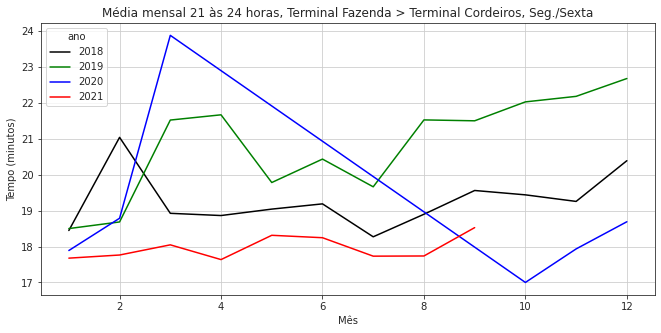

In [41]:
# Terminal Fazenda > Terminal Cordeiros, 21-24
fig, ax = pyplot.subplots(figsize=(11, 5))
plot_fc_dados_21_24 = sns.lineplot(data=fc_dados_21_24, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
plot_fc_dados_21_24.set_title(
    "Média mensal 21 às 24 horas, Terminal Fazenda > Terminal Cordeiros, Seg./Sexta")
plot_fc_dados_21_24.set_xlabel("Mês", fontsize=10)
plot_fc_dados_21_24.set_ylabel("Tempo (minutos)", fontsize=10)
fig.savefig('plots/Fazenda_Cordeiros_21_24.png')
